In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
100%|█████████▉| 170459136/170498071 [00:55<00:00, 6164747.65it/s]Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


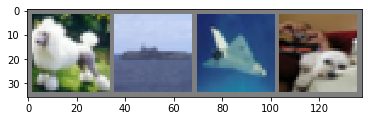

dog ship plane dog


In [15]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(trainloader)
images, labels = data_iter.next()

img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

print(' '.join(f"{classes[j]}" for j in labels))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1} {i + 1}] {running_loss}")
            running_loss = 0.0        

170500096it [01:10, 6164747.65it/s][1 2000] 4574.046232104301
[1 4000] 3994.355021059513
[1 6000] 3491.4610683918
[1 8000] 3256.9745631217957
[1 10000] 3084.515135228634
[1 12000] 2986.3272247612476
[2 2000] 2839.1807570159435
[2 4000] 2778.7383069619536
[2 6000] 2750.2344023287296
[2 8000] 2709.5218824334443
[2 10000] 2662.3858685195446
[2 12000] 2633.546149507165
[3 2000] 2532.695131033659
[3 4000] 2486.2122936472297
[3 6000] 2448.8776298239827
[3 8000] 2387.4314004927874
[3 10000] 2413.3878779783845
[3 12000] 2402.1791290938854


In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

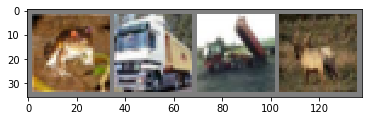

frog truck truck deer


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

print(' '.join(f"{classes[j]}" for j in labels))

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(' '.join(f"{classes[j]}" for j in predicted))

frog truck truck frog


In [23]:
correct = 0
total = 0

raw_score = dict()
for i in range(len(classes)):
    raw_score[i] = ([], [])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(4):
            for cls_i in range(len(classes)):
                raw_score[cls_i][0].append(1 if cls_i == labels[i] else 0)
                raw_score[cls_i][1].append(outputs[i][cls_i])
            

print(f"{correct} / {total}, {correct/total}")

30823 / 50000, 0.61646


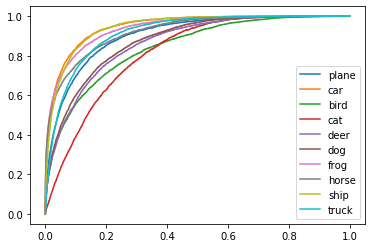

In [24]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(raw_score[i][0], raw_score[i][1])
    plt.plot(fpr[i], tpr[i], label=classes[i])
    
plt.legend()
plt.show()s